$\def\tcoreleft{\underset{\tiny\mid}{\textcolor{MidnightBlue}{⦸}}}$
$\def\tcorecenter{\underset{\tiny\mid}{\textcolor{RedOrange}{⦿}}}$
$\def\tcoreright{\underset{\tiny\mid}{\textcolor{MidnightBlue}{\oslash}}}$
<h1 style="text-align: center;"><b>TMQS Workshop 2024</b> @ Zuse Institute Berlin</h1>
<h2 style="text-align: center;">Summer School on Tensor Methods for Quantum Simulation</h2>
<h2 style="text-align: center;">June 3 - 5, 2024</h2>
<h1 style="text-align: center; background-color:#D6EAF8 ;padding:50px">$\tcoreleft - \tcoreleft - \tcoreleft - \cdots - \tcorecenter - \cdots - \tcoreright - \tcoreright$</h1>
</br>

***

## **Session 3 - Optimization and Simulation in TT format**

***

## Exercise 3.1

Now, let's look at a well-known example for supervised learning problem which involves the classification of handwritten digits. One of the frequently used datasets in this context is the so-called MNIST dataset. It actually contains 60,000 training images and 10,000 test images with their corresponding classes (i.e., 0,...,9). To reduce computation time, we will examine a reduced dataset extracted from the MNIST dataset. This consists of images with 7x7 pixels, representing only the digits 0 and 1. We have 500 training images and 100 test images at our disposal.

**a)**$\quad$Load the dataset and take a look at some of the training images:

> data = np.load('MNIST_full.npz')

$\hspace{0.8cm}$You can access the arrays ```x_train, y_train, x_test, y_test``` by, e.g., ```data['x_train']```.

$\hspace{0.8cm}$The arrays ```x_train``` and ```x_test``` have shape $49 \times 500$ and $49 \times 100$, respectively and contain the (flattened) images.

$\hspace{0.8cm}$The arrays ```y_train``` and ```y_test``` have shape $2 \times 500$ and $2 \times 100$, respectively and contain the corresponding classes (in one-hot encoding).

**b)**$\quad$For the construction of the transformed data tensor $\mathbf{\Theta}$, we choose the two basis functions $\sin(\alpha x)$ and $\cos(\alpha x)$ with $\alpha=0.5 \pi$.

$\hspace{0.8cm}$For this purpose, we use the functions from scikit_tt.data_driven.transform, i.e.,

> import scikit_tt.data_driven.transform as tdt
>
> basis_list = []
> 
> for i in range(order):
> 
> &nbsp;&nbsp; basis_list.append([tdt.Cos(i, alpha), tdt.Sin(i, alpha)])

$\hspace{0.8cm}$Note that ```order``` is simply the number of pixels.

**c)**$\quad$In the next step, we define the initial guess $\mathbf{\Xi}$ for the optimization problems

$\hspace{1.25cm}$$\displaystyle \min_{\mathbf{\Xi} \in \mathbb{T}} \lVert \mathbf{\Xi}^\top \mathbf{\Theta}  - Y_i \rVert_F$,

$\hspace{0.8cm}$where $Y_i$ denotes the $i$th row of ```y_train```. We specify that $\mathbb{T}$ here consists only of tensor trains with a TT rank of 1, i.e.,

> cores = [np.ones([1, 2, 1, 1]) for i in range(order)]
>
> initial_guess = TT(cores).ortho()

**d)**$\quad$Finally, we use the ARR routine from ```scikit_tt.data_driven.regression``` to optimize the tensors for the individual learning problems:

> import scikit_tt.data_driven.regression as reg
>
> xi = reg.arr(x_train, y_train, basis_list, initial_guess, repeats=5, progress=False)

**e)**$\quad$To apply our coefficient tensors to the test data, we construct the corresponding transformed data tensor:

> Theta = tdt.basis_decomposition(x_test, basis_list).transpose(cores=49)

$\hspace{0.8cm}$The corresponding (approximate) label vectors can then be computed by contracting the coefficient tensors with $\mathbf{\Theta}$. 

$\hspace{0.8cm}$For example, the label vector for class 0 can be computed as follows:

> xi_0 = TT(xi[0].cores + [np.ones([1,1,1,1])])
>
> y_0 = (xi_0.transpose()@Theta).matricize()

$\hspace{0.8cm}$Give these lines some thought!

**e)**$\quad$The row indices of the largest entries of $\begin{pmatrix} - y_0 - \\ - y_1 - \end{pmatrix}$ determine the detected labels. Compute the classification rate!

***

$\textcolor{red}{\textbf{SOLUTION:}}$

**a)**

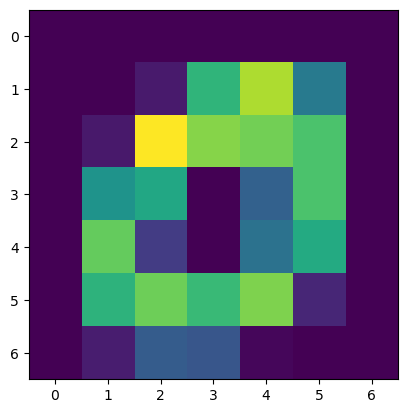

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('MNIST_reduced.npz')
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

plt.imshow(x_train[:,11].reshape([7,7]))
plt.show()

**b)**

In [13]:
import scikit_tt.data_driven.transform as tdt

order = 49
alpha = 0.5 * np.pi
basis_list = []
for i in range(order):
    basis_list.append([tdt.Cos(i, alpha), tdt.Sin(i, alpha)])

**c)**

In [6]:
from scikit_tt.tensor_train import TT

cores = [np.ones([1, 2, 1, 1]) for i in range(order)]
initial_guess = TT(cores).ortho()

**d)**

In [7]:
import scikit_tt.data_driven.regression as reg

xi = reg.arr(x_train, y_train, basis_list, initial_guess, repeats=5, progress=False)

**e)**

In [8]:
Theta = tdt.basis_decomposition(x_test, basis_list).transpose(cores=49)
xi_0 = TT(xi[0].cores + [np.ones([1,1,1,1])])
xi_1 = TT(xi[1].cores + [np.ones([1,1,1,1])])
y_0 = (xi_0.transpose()@Theta).matricize()
y_1 = (xi_1.transpose()@Theta).matricize()

**f)**

In [9]:
inds = np.argmax(np.vstack([y_0, y_1]), axis=0)
sol = np.zeros([2,100])
sol[inds, np.arange(0,100)] = 1
classification_rate = 100 - np.sum(np.abs(sol - y_test)) / 2
print('classification rate:', classification_rate)

classification rate: 99.0


***

## Exercise 3.2 

To conclude, let's take a look at a modified version of an established model for the CO oxidation at RuO2(110), which is a popular fruit-fly system in the theoretical study of heterogeneous catalysis (i.e., a type of catalysis in which the phase of the catalyst differs from that of the reactants). In multiscale models of heterogeneous catalysis, one crucial point is the solution of a Markovian master equation describing the stochastic reaction kinetics. This usually is too high-dimensional to be solved with standard numerical techniques
and one has to rely on sampling approaches based on the kinetic Monte Carlo method. Here, we want to break the curse of dimensionality for the direct solution of the Markovian master equation by exploiting the TT Format.

The state space of the model is $3^d$, where $d$ is the number of reaction sites in our model (coupled in a nearest-neighbor fashion). That is, each site can be in three different states: $0 = \text{empty}$, $1 = \text{O-covered}$, $2 = \text{CO-covered}$.

There are seven elementary reactions:

- **O$_2$ adsorption:** if two neighboring sites are empty, they can adsorb a O$_2$ molecule such that both sites are O-covered afterwards
- **CO adsorption:** if one site is empty, it can adsorb a CO molecule such that the site is CO-covered afterwards
- **O$_2$ desorption:** reversed process of the O$_2$ adsorption
- **CO desorption:** reversed process of the CO adsorption
- **CO$_2$ desorption:** if two neighboring sites are covered by CO and O, respectively, a (gaseous) CO$_2$ molecule can be formed
- **O diffusion:** an adsorbed O atom can move from one site to a neighboring one
- **CO diffusion:** an adsorbed O atom can move from one site to a neighboring one

The corresponding reaction rate constants are 

- k_ad_o2=1
- k_ad_co=0.01
- k_de_o2=0.001 
- k_de_co=1
- k_de_co2=1
- k_diff_o=0.0001
- k_diff_co=0.0001

**a)**$\quad$First, we build the infinitesimal generator of our model. 

$\hspace{0.8cm}$An entry (transition rate) of this tensor is equal to the reaction rate constant of the corresponding reaction (if there exists one). 

$\hspace{0.8cm}$For this, we use the automatic construction of SLIM decompositions for nearest-neighbor interaction systems provided by Scikit-TT. 

$\hspace{0.8cm}$In order to do this, you have to define two lists (of lists): ```single_cell_reactions``` and ```two_cell_reactions```.

$\hspace{0.8cm}$The list ```single_cell_reactions```is given by 

> single_cell_reactions = [[0, 2, k_ad_co],  [2, 0, k_de_co]]

$\hspace{0.8cm}$The first number in each list represents the state of a site before the reaction, the second number is the state after the reaction.

$\hspace{0.8cm}$Define the list ```two_cell_reactions```! Here each entry is a list of the form

> [state of site 1 before, state of site 1 afterwards, state of site 2 before, state of site 2 afterwards, reaction rate constant]```

$\hspace{0.8cm}$Then you can automatically construct the operator by

> import scikit_tt.slim as slim
> 
> operator = slim.slim_mme_hom([3] * d,  single_cell_reactions,  two_cell_reactions,  cyclic=True)

$\hspace{0.8cm}$where ```d``` denotes the order of the system, i.e., the number of sites.

$\hspace{0.8cm}$The last argument ensures that we have a cyclic TT operator in order to mimic an infinite surface. Therefore, the last site is reaction-wise connected to the first one.

**b)**$\quad$We want to simulate the corresponding master equation up to time $T=1000$ until the system relaxed to a steady state.

$\hspace{0.8cm}$Define the initial value:

> initial_value = tt.unit(operator.row_dims, [1] * operator.order)

$\hspace{0.8cm}$To simulate the system, we use the implicit Euler method, which is available in ```scikit_tt.solvers.ode```:

> solution = ode.implicit_euler(operator, initial_value, initial_guess, step_sizes=[1]*T, repeats=2, progress=False)

$\hspace{0.8cm}$Here, the TT instance ```initial_guess``` defines the initial guess for each time step. You can use:

> initial_guess = tt.ones(operator.row_dims, [1] * operator.order, ranks=r).ortho()

$\hspace{0.8cm}$where ```r``` is the rank of the TT representation.

**c)**$\quad$Run the simulations for $d=20$ (How many states do we consider here?) and $r=1,3,5$ and compute the turn-over frequencies (TOFs) for different reactions. 

$\hspace{0.8cm}$A TOF measure how often a reaction is executed per unit time and unit surface.

$\hspace{0.8cm}$Compute the TOFs for the following reactions: CO adsorption, CO desorption, CO$_2$ desorption, O$_2$ adsorption, O$_2$ desorption.

$\hspace{0.8cm}$You can use the follwing routines:

In [ ]:
def single_cell_tof(t, reactant_state, reaction_rate):
    tt_tmp = [None] * t.order
    for k in range(t.order):
        tt_tmp[k] = tt.ones([1] * t.order, t.row_dims)
        tt_tmp[k].cores[k] = np.zeros([1, 1, t.row_dims[k], 1])
        tt_tmp[k].cores[k][0, 0, reactant_state, 0] = 1
    turn_over_frequency = 0
    for k in range(t.order):
        turn_over_frequency += (reaction_rate / t.order) * (tt_tmp[k] @ t)
    return turn_over_frequency


def two_cell_tof(t, reactant_states, reaction_rate):
    tt_left = [None] * t.order
    tt_right = [None] * t.order
    for k in range(t.order):
        tt_left[k] = tt.ones([1] * t.order, t.row_dims)
        tt_right[k] = tt.ones([1] * t.order, t.row_dims)
        tt_left[k].cores[k] = np.zeros([1, 1, t.row_dims[k], 1])
        tt_left[k].cores[k][0, 0, reactant_states[0], 0] = 1
        tt_right[k].cores[k] = np.zeros([1, 1, t.row_dims[k], 1])
        tt_right[k].cores[k][0, 0, reactant_states[0], 0] = 1
        if k > 0:
            tt_left[k].cores[k - 1] = np.zeros([1, 1, t.row_dims[k - 1], 1])
            tt_left[k].cores[k - 1][0, 0, reactant_states[1], 0] = 1
        else:
            tt_left[k].cores[-1] = np.zeros([1, 1, t.row_dims[-1], 1])
            tt_left[k].cores[-1][0, 0, reactant_states[1], 0] = 1
        if k < t.order - 1:
            tt_right[k].cores[k + 1] = np.zeros([1, 1, t.row_dims[k + 1], 1])
            tt_right[k].cores[k + 1][0, 0, reactant_states[1], 0] = 1
        else:
            tt_right[k].cores[0] = np.zeros([1, 1, t.row_dims[0], 1])
            tt_right[k].cores[0][0, 0, reactant_states[1], 0] = 1
    turn_over_frequency = 0
    for k in range(t.order):
        turn_over_frequency += (reaction_rate / t.order) * (tt_left[k] @ t) + (reaction_rate / t.order) * (tt_right[k] @ t)
    if reactant_states[0]==reactant_states[1]:
        turn_over_frequency *= 0.5
    return turn_over_frequency

$\hspace{0.8cm}$Compare your results which the follwing results obtained by extensive kMC simulations:

$\hspace{1.4cm}$$\text{TOF}_{\text{CO adsorption}} = 3.7335184883e-05$

$\hspace{1.4cm}$$\text{TOF}_{\text{CO desorption}} = 1.5825615091e-05$

$\hspace{1.4cm}$$\text{TOF}_{\text{CO}_2~\text{desorption}} = 2.1509901799e-05$

$\hspace{1.4cm}$$\text{TOF}_{\text{O}_2~\text{adsorption}} = 1.0042688156e-03$

$\hspace{1.4cm}$$\text{TOF}_{\text{O}_2~\text{desorption}} = 9.9351569748e-04])$


***

$\textcolor{red}{\textbf{SOLUTION:}}$

**a)**

In [22]:
import scikit_tt.slim as slim

def co_oxidation(order: int, cyclic: bool = True):

    # reaction rate constants
    k_ad_co=0.01
    k_ad_o2=1
    k_de_co=1
    k_de_o2=0.001
    k_diff_co=0.0001
    k_diff_o=0.0001
    k_de_co2=1,

    # define state space
    state_space = [3] * order
    
    # define operator using automatic construction of SLIM decomposition
    single_cell_reactions = [[0, 2, k_ad_co],  [2, 0, k_de_co]]
    two_cell_reactions = [[0, 1, 0, 1,  k_ad_o2],   [1, 0, 1, 0, k_de_o2],  [2, 0, 1, 0, k_de_co2],
                          [1, 0, 2, 0,  k_de_co2],  [1, 0, 0, 1, k_diff_o], [0, 1, 1, 0, k_diff_o],
                          [0, 2, 2, 0,  k_diff_co], [2, 0, 0, 2, k_diff_co]]
    # define operator
    operator = slim.slim_mme_hom(state_space,  single_cell_reactions,  two_cell_reactions,  cyclic=cyclic)
    
    return operator

**b)**

In [27]:
import scikit_tt.tensor_train as tt

initial_value = tt.unit(operator.row_dims, [1] * operator.order)

**c)**

In [28]:
import scikit_tt.solvers.ode as ode

tofs = np.array([3.7335184883e-05, 1.5825615091e-05, 2.1509901799e-05, 1.0042688156e-03, 9.9351569748e-04])
R = [1, 3, 5]
operator = co_oxidation(order=20,  cyclic=True).ortho()

for i in range(3):
    r = R[i]
    initial_guess = tt.ones(operator.row_dims, [1] * operator.order, ranks=r).ortho()
    solution = ode.implicit_euler(operator, initial_value, initial_guess, step_sizes=[1]*1000, repeats=2, progress=False)
    print('rank:', r)
    print('closeness: ', (operator@solution[-1]).norm())
    print('CO adsorption:', np.abs(single_cell_tof(solution[-1], 0, 0.01) - tofs[0])/tofs[0])   # CO adsorption
    print('CO desorption:', np.abs(single_cell_tof(solution[-1], 2, 1) - tofs[1])/tofs[1])      # CO desorption
    print('CO2 desorption:', np.abs(two_cell_tof(solution[-1], [2,1], 1) - tofs[2])/tofs[2])     # CO2 desorption
    print('O2 adsorption:', np.abs(two_cell_tof(solution[-1], [0,0], 1) - tofs[3])/tofs[3])     # O2 adsorption
    print('O2 desorption:', np.abs(two_cell_tof(solution[-1], [1,1], 0.001) - tofs[4])/tofs[4]) # O2 desorption
    print(' ')

rank: 1
closeness:  0.02049389927055082
CO adsorption: 0.9999985033320705
CO desorption: 0.9999988212074029
CO2 desorption: 0.9999982654390752
O2 adsorption: 0.9999999999998999
O2 desorption: 0.0065266118325683475
 
rank: 3
closeness:  2.854591698491477e-05
CO adsorption: 0.03535894872072331
CO desorption: 0.025410651666284444
CO2 desorption: 0.03523120468111328
O2 adsorption: 0.002271096173509499
O2 desorption: 0.00026421613477488315
 
rank: 5
closeness:  1.993406525169611e-05
CO adsorption: 0.036540695417844236
CO desorption: 0.037659732726426226
CO2 desorption: 0.050786659054062204
O2 adsorption: 0.0021937656676205898
O2 desorption: 0.0002735168507174837
 
